In [16]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

In [17]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
path = '/content/drive/MyDrive/5A 1C/Plataformas de Computación Cognitiva/Trabajo Practico 3/TPs/TP3'

In [19]:
# Load the model
model = load_model(f'{path}/converted_keras/keras_model.h5', compile=False)

# Load the labels
class_names = open(f'{path}/converted_keras/labels.txt', "r").readlines()

In [20]:
# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open(f"{path}/RealWaste/Test/Organico/Imagen3.jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 2s 2s/step
Class: Plastico
Confidence Score: 0.3830054


In [21]:
import os
# Prepare to collect predictions
predictions = []

# Loop through each category directory
# Clean up the category names by stripping newline characters and spaces
categories = os.listdir(f'{path}/RealWaste/Test')
categories = [name.split(' ', 1)[1] if ' ' in name else name for name in categories]

for category in categories:
    category_path = f'{path}/RealWaste/Test/{category}'
    images = os.listdir(category_path)

    for image_name in images:
        if image_name.endswith('.jpg') | image_name.endswith('.png'):  # Ensure it's an image
            # Open and process the image
            image_path = os.path.join(category_path, image_name)
            image = Image.open(image_path).convert("RGB")
            image = ImageOps.fit(image, (224, 224), Image.Resampling.LANCZOS)

            image_array = np.asarray(image)

            # Create batch data
            data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

            # Normalize the image
            normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

            data[0] = normalized_image_array

            # Predict
            prediction = model.predict(data)
            index = np.argmax(prediction)
            class_name = class_names[index]
            confidence_score = prediction[0][index]

            # Store or print predictions
            predictions.append((image_name, category, class_name.split(' ', 1)[1].strip(), confidence_score))
            print(f"Image: {image_name}, Real Class: {category}, Predicted Class: {class_name}, Confidence: {confidence_score}")


1/1 [==============================] - 0s 58ms/step
Image: Imagen1.jpg, Real Class: Plastico, Predicted Class: 2 Vidrio
, Confidence: 0.6332729458808899
1/1 [==============================] - 0s 61ms/step
Image: Imagen2.jpg, Real Class: Plastico, Predicted Class: 4 Otro (Miscelaneo)
, Confidence: 0.9999686479568481
1/1 [==============================] - 0s 58ms/step
Image: Imagen3.jpg, Real Class: Plastico, Predicted Class: 4 Otro (Miscelaneo)
, Confidence: 0.5335167050361633
1/1 [==============================] - 0s 61ms/step
Image: Imagen4.jpg, Real Class: Plastico, Predicted Class: 6 Plastico
, Confidence: 0.8926175236701965
1/1 [==============================] - 0s 71ms/step
Image: Imagen5.jpg, Real Class: Plastico, Predicted Class: 6 Plastico
, Confidence: 0.9972200393676758
1/1 [==============================] - 0s 71ms/step
Image: Imagen1.jpg, Real Class: Papel, Predicted Class: 5 Papel
, Confidence: 0.9999735355377197
1/1 [==============================] - 0s 81ms/step
Image: I

In [22]:
import pandas as pd
df = pd.DataFrame(predictions)
df.columns = ['Image Name', 'Real Class', 'Predicted Class', 'Confidence Score']

In [23]:
df.tail()

,Image Name,Real Class,Predicted Class,Confidence Score
30,Imagen1.png,Textil,Papel,0.425123
31,Imagen2.png,Textil,Textil,0.999959
32,Imagen3.png,Textil,Papel,1.000000
33,Imagen4.png,Textil,Papel,0.999999
34,Imagen5.png,Textil,Otro (Miscelaneo),0.712299


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

true_labels = df['Real Class']
predictions = df['Predicted Class']
model_name = "TeachableMachine"

report = classification_report(true_labels, predictions, output_dict=True)
conf_matrix = confusion_matrix(true_labels, predictions, labels=['Plastico', 'Carton', 'Metal', 'Organico', 'Papel', 'Textil', 'Vidrio', 'Otros (Miscelaneo)'])

# Calcular especificidad: TN / (TN + FP)
# Para un problema de multi-clase, calculamos la especificidad para cada clase y luego promediamos.
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)

avg_specificity = sum(specificity) / len(specificity)

# Crear un DataFrame para guardar los resultados
results = pd.DataFrame()

# Guardar métricas en el DataFrame
results.loc[model_name, 'Accuracy'] = report['accuracy']
results.loc[model_name, 'Precision'] = report['weighted avg']['precision']
results.loc[model_name, 'Recall'] = report['weighted avg']['recall']
results.loc[model_name, 'F1-Score'] = report['weighted avg']['f1-score']
results.loc[model_name, 'Specificity'] = avg_specificity

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


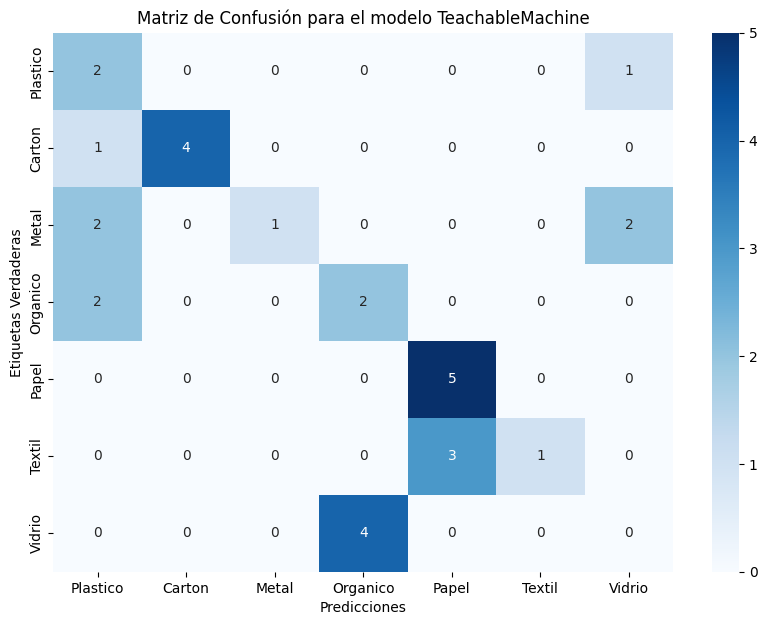

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions, labels=['Plastico', 'Carton', 'Metal', 'Organico', 'Papel', 'Textil', 'Vidrio'])

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Plastico', 'Carton', 'Metal', 'Organico', 'Papel', 'Textil', 'Vidrio'],
            yticklabels=['Plastico', 'Carton', 'Metal', 'Organico', 'Papel', 'Textil', 'Vidrio'])
plt.title(f'Matriz de Confusión para el modelo {model_name}')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

In [26]:
results.head()

,Accuracy,Precision,Recall,F1-Score,Specificity
TeachableMachine,0.428571,0.606293,0.428571,0.431679,0.928198


In [28]:
report

{'Carton': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.888888888888889,
  'support': 5},
 'Metal': {'precision': 1.0,
  'recall': 0.2,
  'f1-score': 0.33333333333333337,
  'support': 5},
 'Organico': {'precision': 0.3333333333333333,
  'recall': 0.4,
  'f1-score': 0.3636363636363636,
  'support': 5},
 'Otro (Miscelaneo)': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 0},
 'Papel': {'precision': 0.625,
  'recall': 1.0,
  'f1-score': 0.7692307692307693,
  'support': 5},
 'Plastico': {'precision': 0.2857142857142857,
  'recall': 0.4,
  'f1-score': 0.3333333333333333,
  'support': 5},
 'Textil': {'precision': 1.0,
  'recall': 0.2,
  'f1-score': 0.33333333333333337,
  'support': 5},
 'Vidrio': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 'accuracy': 0.42857142857142855,
 'macro avg': {'precision': 0.5305059523809523,
  'recall': 0.375,
  'f1-score': 0.3777195027195027,
  'support': 35},
 'weighted avg': {'precision': 0.6062925170068028,
  